In [1]:
# Import required libraries
import torch  # PyTorch library for building the neural network
import torch.nn as nn  # PyTorch module for defining neural network layers
import torch.optim as optim  # Optimizers like Adam for training
import pandas as pd  # Data handling and manipulation
from sklearn.model_selection import train_test_split  # For splitting dataset into training, validation, and test sets
from sklearn.preprocessing import StandardScaler  # For normalizing the data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Evaluation metrics
import matplotlib.pyplot as plt  # For visualizing results

In [2]:
# Load the dataset from a local path in Colab
data = pd.read_csv(r'/content/Housing-1.csv')
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [3]:
# Preprocess the dataset (handling missing values and encoding categorical variables using one-hot encoding)
data = pd.get_dummies(data, drop_first=True)
data.head()

,price,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,2,True,False,False,False,True,True,False,False
1,12250000,8960,4,4,4,3,True,False,False,False,True,False,False,False
2,12250000,9960,3,2,2,2,True,False,True,False,False,True,True,False
3,12215000,7500,4,2,2,3,True,False,True,False,True,True,False,False
4,11410000,7420,4,1,2,2,True,True,True,False,True,False,False,False


In [4]:
# Define X as the feature set (all columns except 'price') and y as the target variable (price)
X = data.drop(columns=['price'])
y = data['price']

In [5]:
# Split the data into training (70%), validation (15%), and testing sets (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# Normalize the feature set using StandardScaler
scaler = StandardScaler()  # Instantiate the scaler
X_train = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
X_val = scaler.transform(X_val)  # Apply the same transformation on validation data
X_test = scaler.transform(X_test)  # Apply the same transformation on test data


In [7]:
# Normalize the target variable (price) using StandardScaler
y_scaler = StandardScaler()  # Instantiate another scaler for the target variable
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))  # Reshape and fit-transform the training target
y_val = y_scaler.transform(y_val.values.reshape(-1, 1))  # Transform the validation target
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))  # Transform the test target

In [8]:
# Convert data to PyTorch tensors (required for model input)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape target to 2D tensor
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [9]:
# Define the neural network model as a class
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        # Define the first fully connected layer with input size equal to the number of features and 512 neurons
        self.fc1 = nn.Linear(X_train.shape[1], 512)
        # Define the second fully connected layer with 512 neurons
        self.fc2 = nn.Linear(512, 512)
        # Define a dropout layer with a probability of 0.4 to avoid overfitting
        self.dropout = nn.Dropout(0.5)
        # Define a third fully connected layer
        self.fc3 = nn.Linear(512, 512)
        # Another dropout layer to regularize the model
        self.dropout = nn.Dropout(0.5)

        self.fc4 = nn.Linear(512, 1)  # Final output layer with 1 neuron (price prediction)

    def forward(self, x):
        # Define the forward pass with ReLU activation functions
        x = torch.relu(self.fc1(x))  # Apply ReLU activation after first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation after second layer
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc3(x))  # Apply ReLU activation after third layer
        x = self.dropout(x)  # Apply another dropout
        x = self.fc4(x)  # Output layer (no activation here since this is regression)
        return x




In [10]:
# Initialize the model, define the loss function (Mean Squared Error), and the optimizer (Adam)
model = ANNModel()
criterion = nn.MSELoss()  # MSE loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.00005)  # Adam optimizer with a learning rate of 0.00005

In [11]:
# Define early stopping parameters
patience = 10  # Number of epochs to wait after no improvement
best_val_loss = float('inf')  # Initialize best validation loss to infinity
early_stop_count = 0  # Count the number of epochs without improvement

# Lists to store training and validation losses
train_losses = []
val_losses = []

In [12]:
# Training loop with validation and early stopping
num_epochs = 100  # Number of epochs to train
batch_size = 32  # Batch size for mini-batch gradient descent
train_data = torch.utils.data.TensorDataset(X_train, y_train)  # Create dataset from tensors
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)  # Create data loader
# Loop over each epoch
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0  # Initialize epoch loss
    for batch_X, batch_y in train_loader:  # Loop through each batch
        y_pred = model(batch_X)  # Forward pass: predict output for batch
        loss = criterion(y_pred, batch_y)  # Compute loss

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero out gradients
        loss.backward()  # Backpropagate loss
        optimizer.step()  # Update weights

        epoch_loss += loss.item()  # Accumulate the loss for this epoch

    epoch_loss /= len(train_loader)  # Compute average loss for this epoch
    train_losses.append(epoch_loss)  # Store training loss

    # Validation step
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for validation
        y_pred_val = model(X_val)  # Predict validation set
        val_loss = criterion(y_pred_val, y_val).item()  # Compute validation loss
        val_losses.append(val_loss)  # Store validation loss

    # Print epoch number, training loss, and validation loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Early stopping condition based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # Update the best validation loss
        early_stop_count = 0  # Reset the early stopping counter
    else:
        early_stop_count += 1  # Increment the early stopping counter

    # Stop training if validation loss hasn't improved for 'patience' epochs
    if early_stop_count >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break



Epoch [1/100], Training Loss: 1.0082, Validation Loss: 1.3153
Epoch [2/100], Training Loss: 0.9218, Validation Loss: 1.2319
Epoch [3/100], Training Loss: 0.8431, Validation Loss: 1.1434
Epoch [4/100], Training Loss: 0.7746, Validation Loss: 1.0466
Epoch [5/100], Training Loss: 0.6798, Validation Loss: 0.9398
Epoch [6/100], Training Loss: 0.6209, Validation Loss: 0.8299
Epoch [7/100], Training Loss: 0.5349, Validation Loss: 0.7300
Epoch [8/100], Training Loss: 0.4459, Validation Loss: 0.6547
Epoch [9/100], Training Loss: 0.3942, Validation Loss: 0.6040
Epoch [10/100], Training Loss: 0.3616, Validation Loss: 0.5768
Epoch [11/100], Training Loss: 0.3500, Validation Loss: 0.5652
Epoch [12/100], Training Loss: 0.3632, Validation Loss: 0.5575
Epoch [13/100], Training Loss: 0.3037, Validation Loss: 0.5497
Epoch [14/100], Training Loss: 0.3150, Validation Loss: 0.5444
Epoch [15/100], Training Loss: 0.3262, Validation Loss: 0.5494
Epoch [16/100], Training Loss: 0.3164, Validation Loss: 0.5515
E

In [13]:
# Evaluation on the test set
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computation for testing
    y_pred_test = model(X_test)  # Predict on the test set
    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    # Print test metrics
    print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}')

MSE: 0.3959, MAE: 0.4758, R-squared: 0.7103


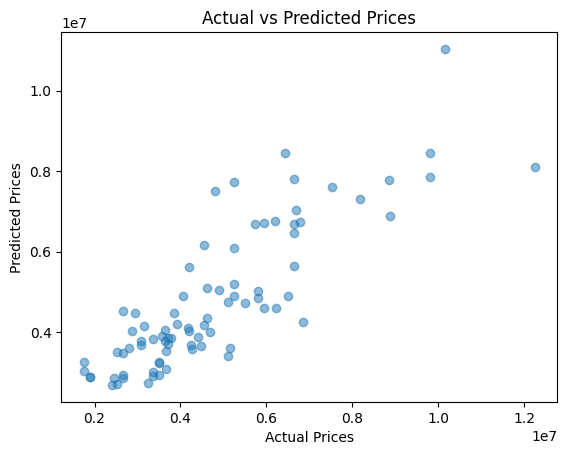

In [14]:
# Visualize the predictions vs actual values
y_pred_test_rescaled = y_scaler.inverse_transform(y_pred_test.numpy())  # Rescale the predictions
y_test_rescaled = y_scaler.inverse_transform(y_test.numpy())  # Rescale the true values

# Plot actual vs predicted prices
plt.scatter(y_test_rescaled, y_pred_test_rescaled, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()


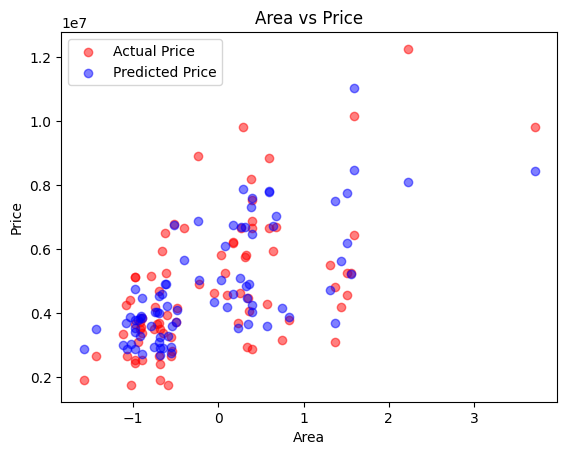

In [15]:
area_test = X_test[:, 0].numpy()

# Scatter plot of area vs actual prices (red)
plt.scatter(area_test, y_test_rescaled, color='red', label='Actual Price', alpha=0.5)

# Scatter plot of area vs predicted prices (blue)
plt.scatter(area_test, y_pred_test_rescaled, color='blue', label='Predicted Price', alpha=0.5)

plt.title('Area vs Price')
plt.xlabel('Area')
plt.ylabel('Price')
plt.legend()
plt.show()

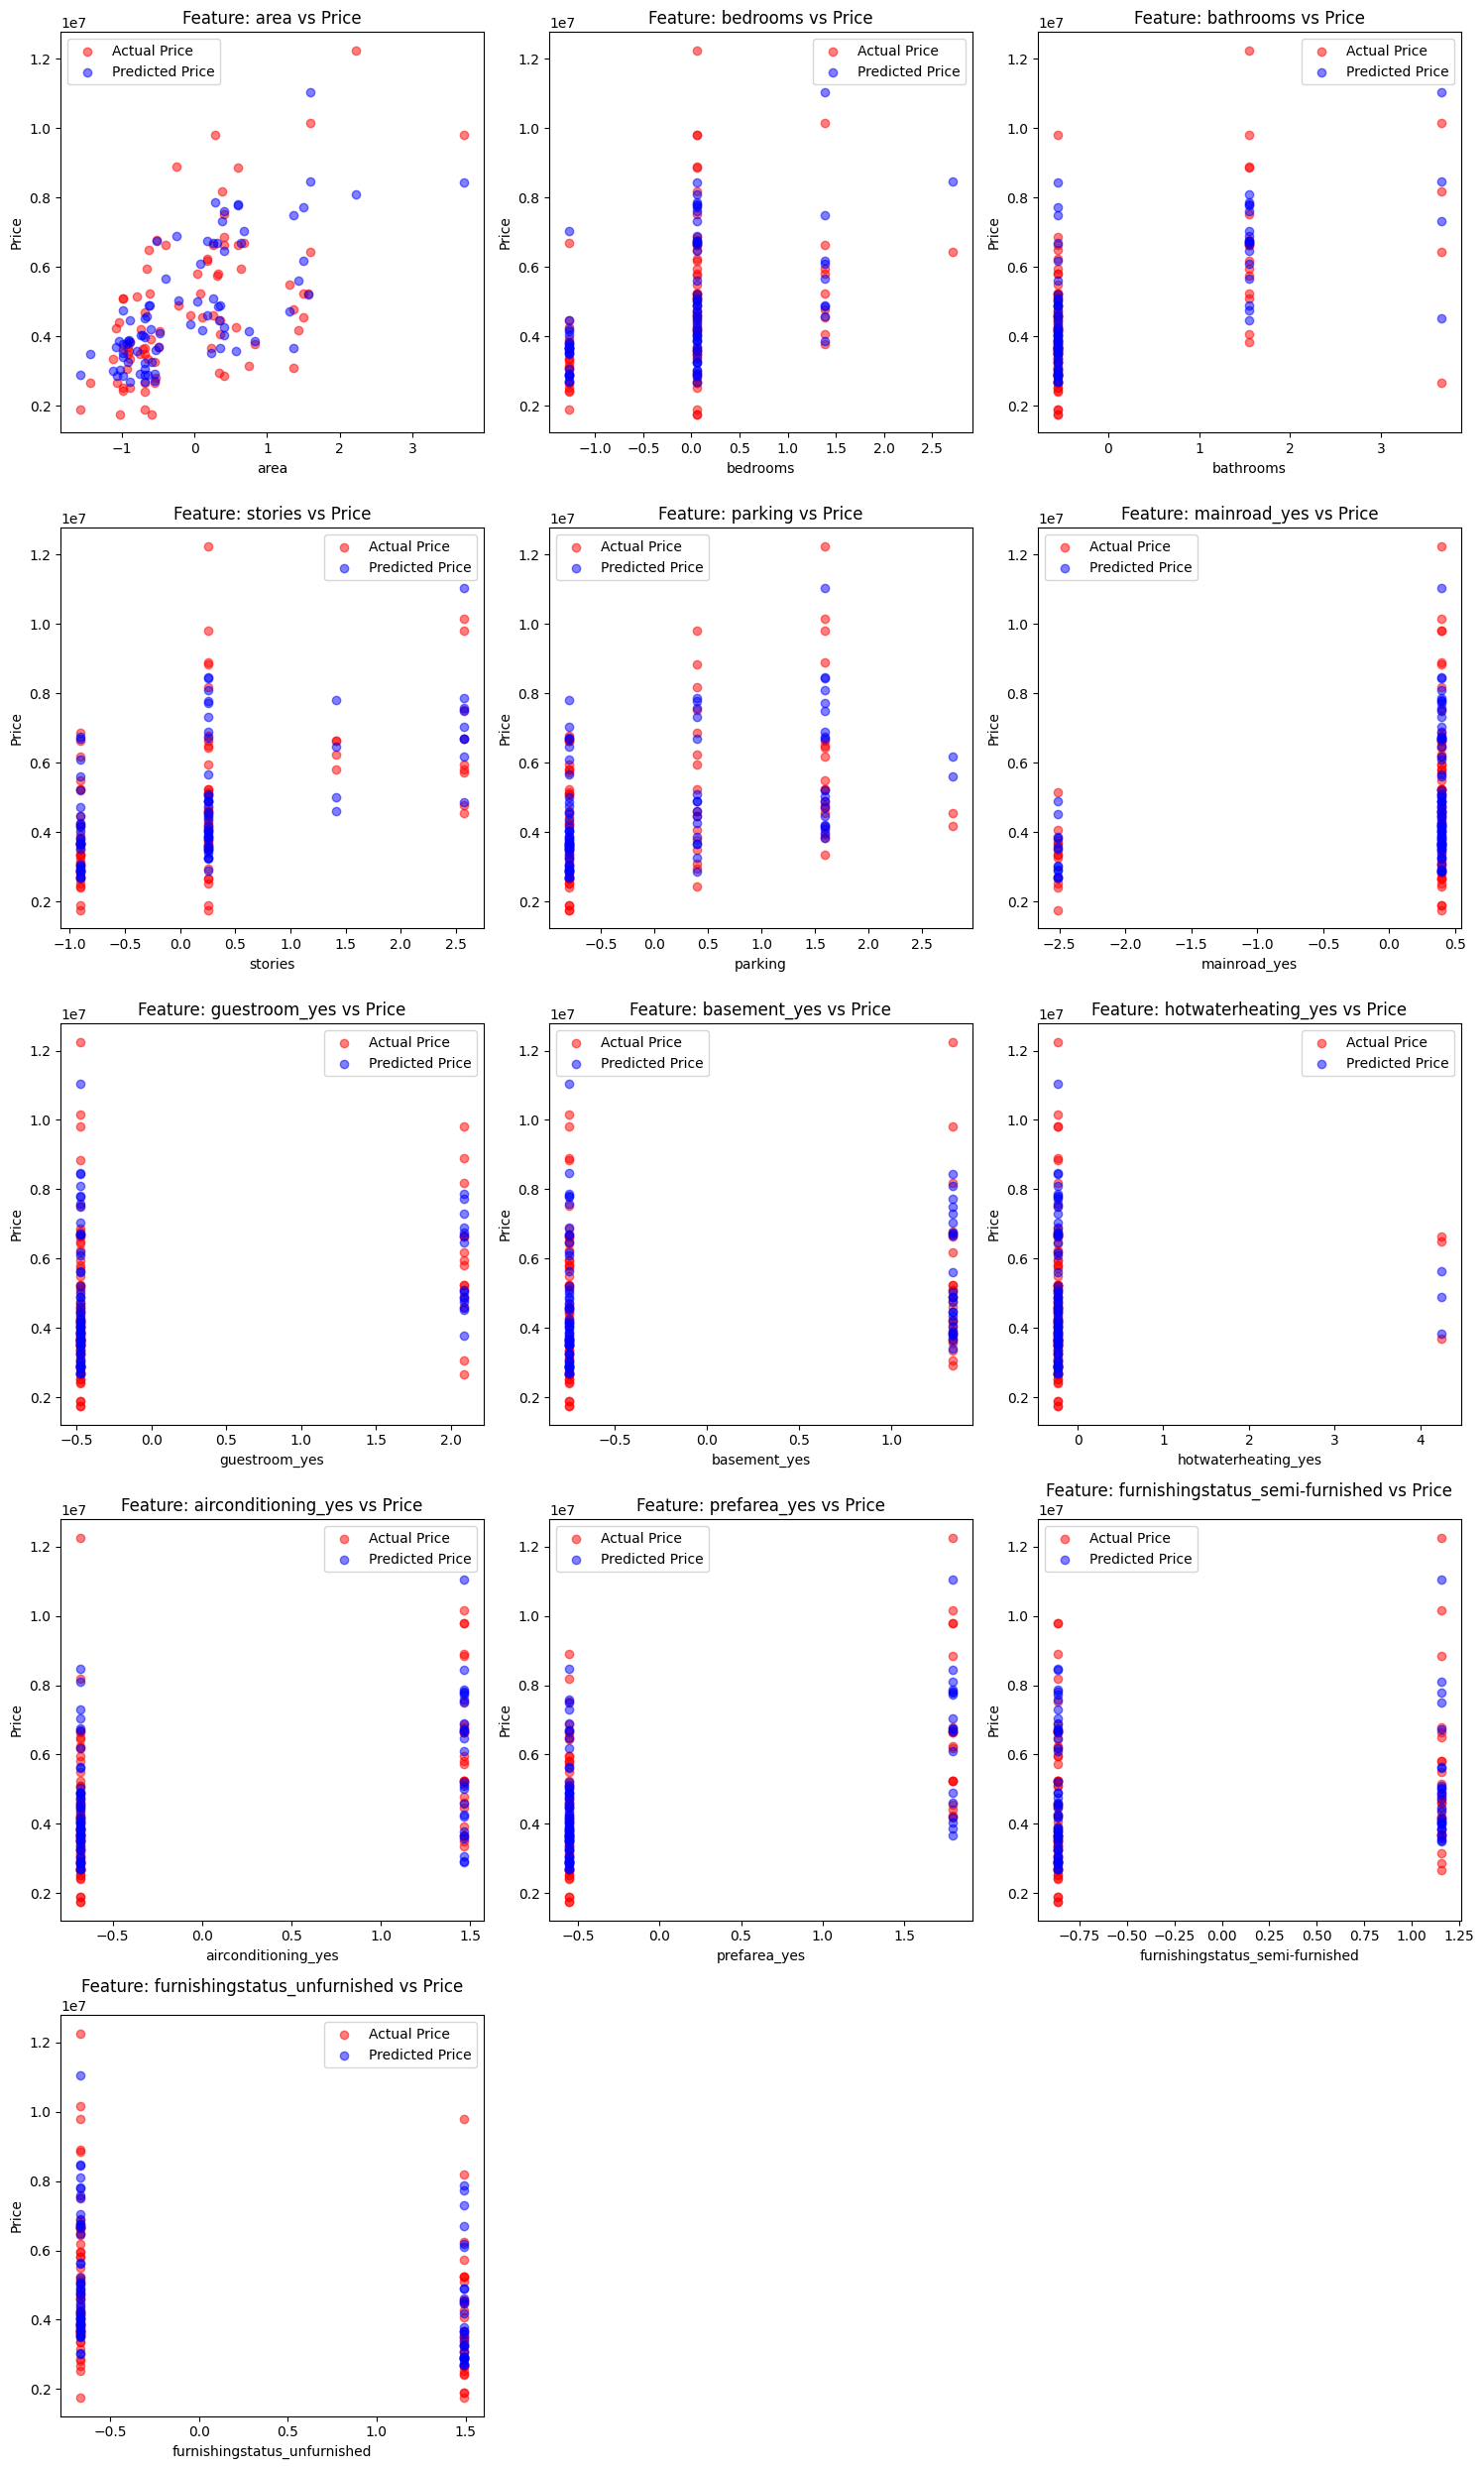

In [16]:
# Visualize each feature against the actual and predicted prices
num_features = X_train.shape[1]
feature_names = X.columns

# Create a figure with subplots
rows = (num_features + 2) // 3  # Calculate the number of rows needed for 3 columns
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

# Flatten axes array for easy indexing
axes = axes.flatten()

# Iterate over each feature and create a scatter plot
for i in range(num_features):
    ax = axes[i]

    # Scatter plot of the feature against actual prices (red)
    ax.scatter(X_test[:, i].numpy(), y_test_rescaled, color='red', label='Actual Price', alpha=0.5)

    # Scatter plot of the feature against predicted prices (blue)
    ax.scatter(X_test[:, i].numpy(), y_pred_test_rescaled, color='blue', label='Predicted Price', alpha=0.5)

    ax.set_title(f'Feature: {feature_names[i]} vs Price')
    ax.set_xlabel(f'{feature_names[i]}')
    ax.set_ylabel('Price')
    ax.legend()

# Hide any empty subplots if num_features is not a multiple of 3
for j in range(num_features, rows * 3):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

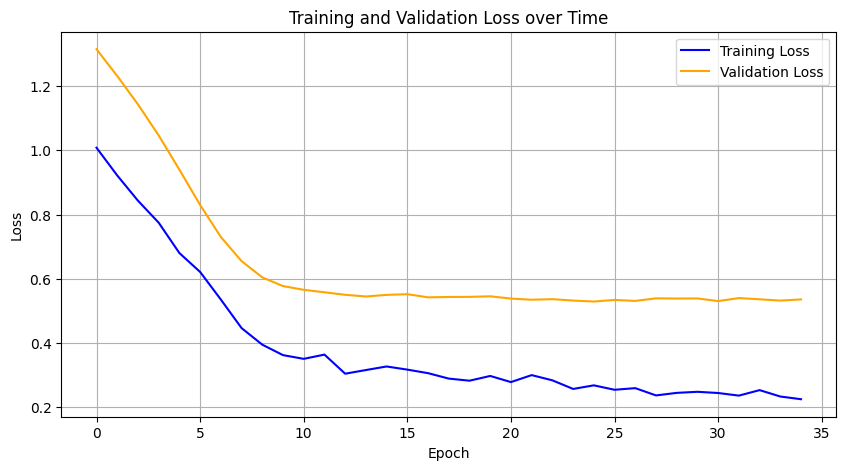

In [17]:
# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 5))  # Set the size of the figure to be 10 inches wide and 5 inches tall
plt.plot(range(len(train_losses)), train_losses, label='Training Loss', color='blue')  # Plot training loss
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss', color='orange')  # Plot validation loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Time')
plt.legend()  # Display legend to differentiate between training and validation losses
plt.grid(True)  # Add a grid to the plot for better readability of the loss values
plt.show()  # Display the plot
